# Лабораторная работа по МО №2

Выполнил: Еремин Илья Владимирович, гр. 3374

Цель: познакомиться с методом кластеризации K-mean с помощью пакета sklearn.

## 1. Изменение текущего набора данных
В текущий датасет был добавлен атрибут соотношения цены и дохода по странам. Пропущенные значения дополнены данными из других источников.

После построения графиков рассеивания можно заметить ярковыраженную группу точек, распределенную от 20 до 80 по оси Y. На графике отношения индекса соотношения цены к доходу и индекса цен в ресторанах есть несколько кластеров, и два из них содержат большое количество точек: первый кластер от 10 до 40 по Y, второй кластер от 50 до 70 по Y. Ещё четко наблюдать разделение на кластеры можно на графике отношения индекса соотношения цены к доходу и индекса местной покупательной способности: первый кластер от 20 до 80 по Y, второй кластер от 90 до 140 по Y.



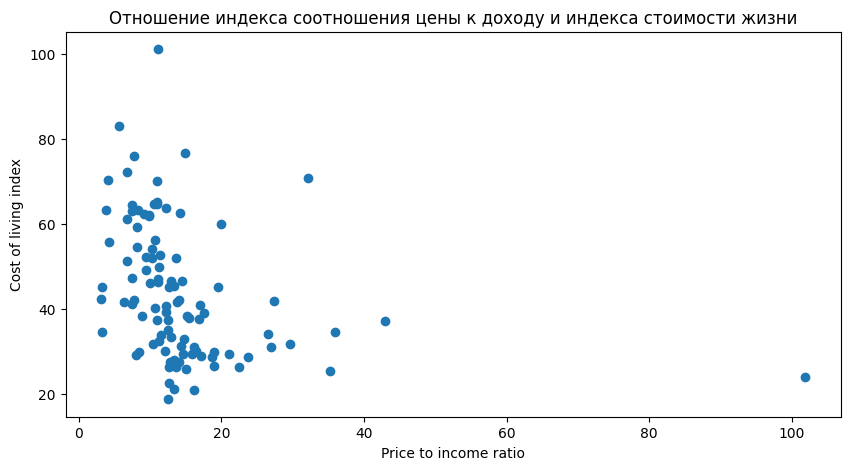

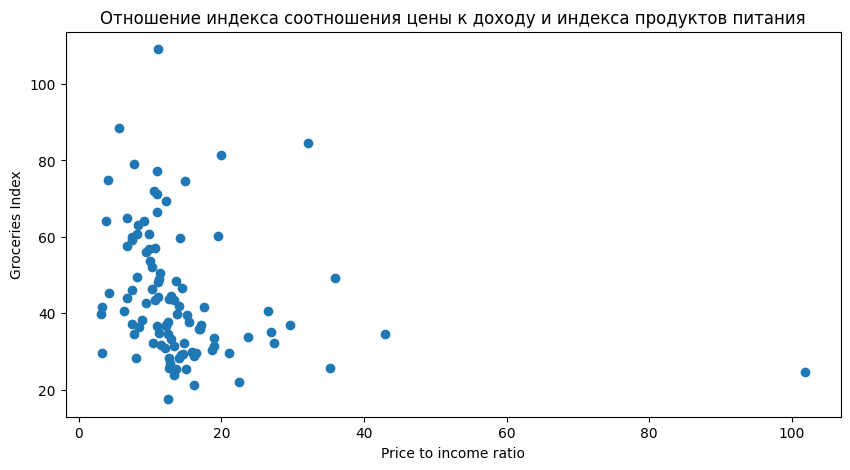

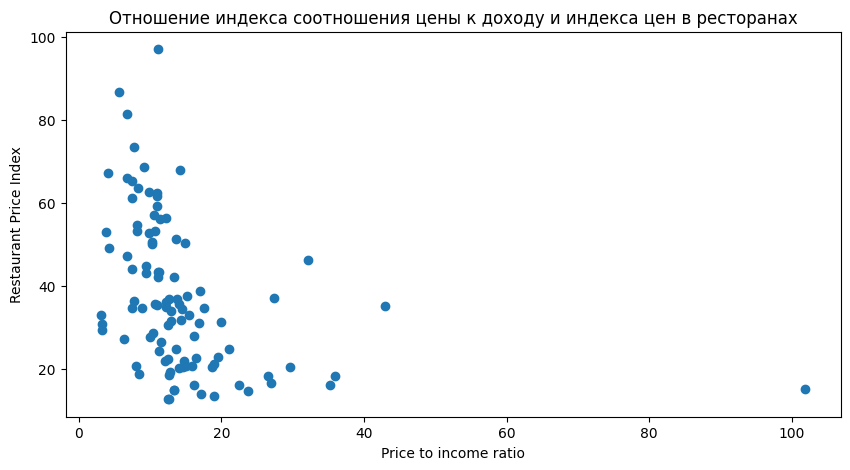

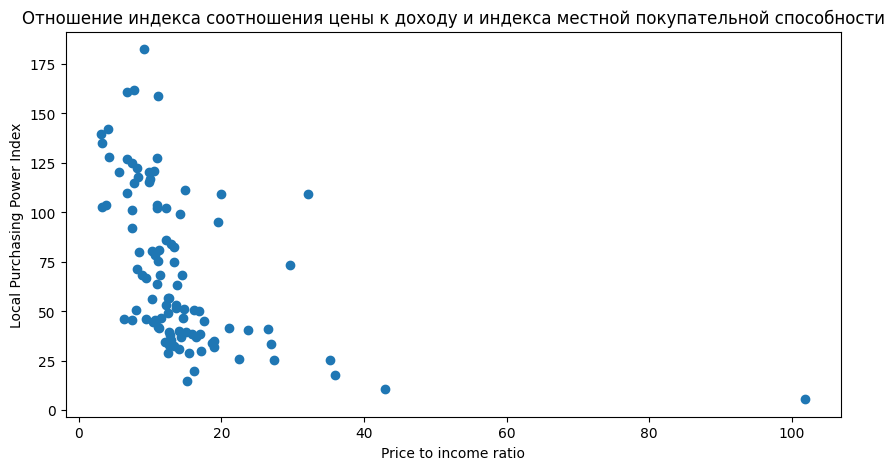

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def fix_european_format(value):
    if pd.isna(value):
        return np.nan
    value = str(value).strip()
    value = value.replace(' ', '').replace(',', '.')
    parts = value.split('.')
    if len(parts) > 2:
        value = parts[0] + '.' + ''.join(parts[1:])
    return value

df = pd.read_csv('Cost_of_Living_Index_by_Country_20242.csv', sep=None, engine='python')
for col in df.columns[2:]:
    df[col] = df[col].apply(fix_european_format)
    df[col] = pd.to_numeric(df[col], errors='coerce')
plt.figure(figsize=(10, 5))
plt.scatter(df['Price To Income Ratio'], df['Cost of Living Index'])
plt.xlabel('Price to income ratio')
plt.ylabel('Cost of living index')
plt.title('Отношение индекса соотношения цены к доходу и индекса стоимости жизни')

plt.figure(figsize=(10, 5))
plt.scatter(df['Price To Income Ratio'], df['Groceries Index'])
plt.xlabel('Price to income ratio')
plt.ylabel('Groceries Index')
plt.title('Отношение индекса соотношения цены к доходу и индекса продуктов питания')

plt.figure(figsize=(10, 5))
plt.scatter(df['Price To Income Ratio'], df['Restaurant Price Index'])
plt.xlabel('Price to income ratio')
plt.ylabel('Restaurant Price Index')
plt.title('Отношение индекса соотношения цены к доходу и индекса цен в ресторанах')

plt.figure(figsize=(10, 5))
plt.scatter(df['Price To Income Ratio'], df['Local Purchasing Power Index'])
plt.xlabel('Price to income ratio')
plt.ylabel('Local Purchasing Power Index')
plt.title('Отношение индекса соотношения цены к доходу и индекса местной покупательной способности')

%matplotlib inline

## 2. Применение метода K-mean

Для того, чтобы применить метод, необходимо нормализовать данные. Далее программа назначает кластеры и применяет метод локтя (Elbow method) для оптимизации числа кластеров. Использование метода локтя подразумевает прохождение трех этапов:
- **1 этап**: для различных значений числа кластеров k вычисляется сумма квадратов расстояний каждой точки данных до их центроида (центра тяжести) (WCSS) по формуле:
$$WCSS=\sum_{j=1}^k \sum_{i=1}^n min(||x_i^j - c_j ||)^2$$
где k - число кластеров, n - количество наблюдений, $x_i^j$ - i-ое наблюдение в j-том кластере, $c_j$ - центроид j-того кластера.
- **2 этап**: построение графика зависимости WCSS от количества кластеров, где по оси X откладывается число кластеров k, а по оси Y - соответствующая сумма квадратов расстояний.
- **3 этап**: поиск точки излома («локтя») на графике, которая указывает на оптимальное число кластеров. Оптимальным k будет то, при котором ошибка перестает существенно уменьшаться, т.е. начинает сглаживаться. В моем случае таким числом будет 3.

После этого создается и обучается модель K-means, и с помощью PCA (Principal Component Analysis) программа визуализирует кластеры. PCA уменьшает размерность данных и преобразует множество коррелированных признаков в меньшее количество некоррелированных переменных, называемых главными компонентами.

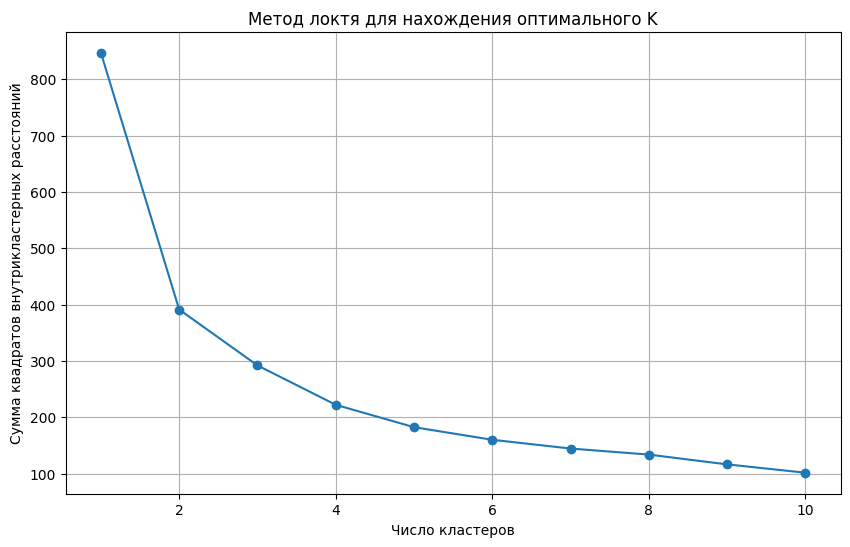

Распределение по кластерам:
Cluster
0    55
1    26
2    40
Name: count, dtype: int64
Объясненная дисперсия PCA: 88.91%


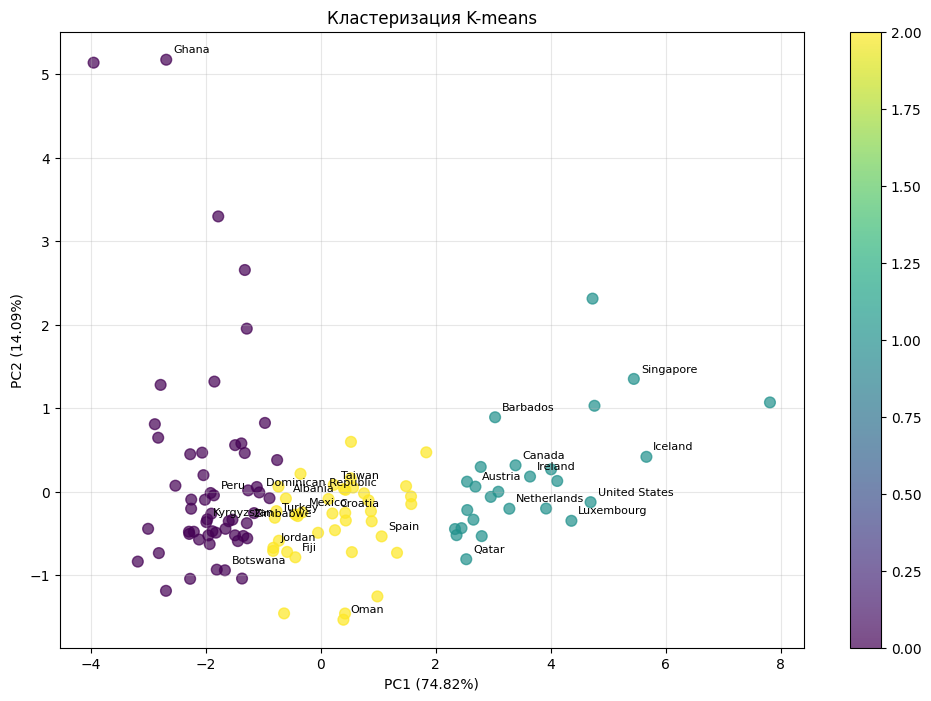

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def fix_european_format(value):
    if pd.isna(value):
        return np.nan
    value = str(value).strip()
    value = value.replace(' ', '').replace(',', '.')
    parts = value.split('.')
    if len(parts) > 2:
        value = parts[0] + '.' + ''.join(parts[1:])
    return value

def find_optimal_clusters(data, max_k=10):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.xlabel('Число кластеров')
    plt.ylabel('Сумма квадратов внутрикластерных расстояний')
    plt.title('Метод локтя для нахождения оптимального K')
    plt.grid(True)
    plt.show()
    
    return inertias

df = pd.read_csv('Cost_of_Living_Index_by_Country_20242.csv', sep=None, engine='python')
for col in df.columns[2:]:
    df[col] = df[col].apply(fix_european_format)
    df[col] = pd.to_numeric(df[col], errors='coerce')

features = df.drop(['Rank', 'Country'], axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

inertias = find_optimal_clusters(features_scaled)

optimal_k = 3

# Создание и обучение модели KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_scaled)

# Добавление кластеров в исходный датасет
df['Cluster'] = clusters
features_scaled_df['Cluster'] = clusters

print("Распределение по кластерам:")
print(df['Cluster'].value_counts().sort_index())
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# Создание DataFrame для визуализации
viz_df = pd.DataFrame({
    'PC1': features_2d[:, 0],
    'PC2': features_2d[:, 1],
    'Cluster': clusters,
    'Country': df['Country']
})

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum():.2%}")

# Визуализация кластеров
plt.figure(figsize=(12, 8))
scatter = plt.scatter(viz_df['PC1'], viz_df['PC2'], c=viz_df['Cluster'], 
                     cmap='viridis', alpha=0.7, s=60)
plt.colorbar(scatter)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('Кластеризация K-means')

for i, country in enumerate(viz_df['Country']):
    if i % 5 == 0:
        plt.annotate(country, (viz_df['PC1'][i], viz_df['PC2'][i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.grid(True, alpha=0.3)
plt.show()

## Вывод
В данной лабораторной работе был изучен и применен метод K-mean (k-средних) с помощью библиотеки sklearn. На построенных графиках визуально удалось определить только 2 кластера, однако после использования метода локтя алгоритм показал, что существует оптимальное число кластеров, равное 3-м. С помощью визуализации PCA можно увидеть эти распределения. Также был проведён анализ дисперсии PCA, в ходе которой выяснилось, что она составляет 88.91%. Это говорит о том, что визуализация хорошо отражает структуру данных и кластеры на графике соответствуют реальным группировкам.